In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

from cosmo_compression.data import data
from cosmo_compression.model import represent

Masking 0 channels out of 64 for batch 0 at timestep 0.00.
Masking 0 channels out of 64 for batch 0 at timestep 0.01.
Masking 1 channels out of 64 for batch 0 at timestep 0.02.
Masking 1 channels out of 64 for batch 0 at timestep 0.03.
Masking 2 channels out of 64 for batch 0 at timestep 0.04.
Masking 3 channels out of 64 for batch 0 at timestep 0.05.
Masking 3 channels out of 64 for batch 0 at timestep 0.06.
Masking 4 channels out of 64 for batch 0 at timestep 0.07.
Masking 5 channels out of 64 for batch 0 at timestep 0.08.
Masking 5 channels out of 64 for batch 0 at timestep 0.09.
Masking 6 channels out of 64 for batch 0 at timestep 0.10.
Masking 7 channels out of 64 for batch 0 at timestep 0.11.
Masking 7 channels out of 64 for batch 0 at timestep 0.12.
Masking 8 channels out of 64 for batch 0 at timestep 0.13.
Masking 9 channels out of 64 for batch 0 at timestep 0.14.
Masking 9 channels out of 64 for batch 0 at timestep 0.15.
Masking 10 channels out of 64 for batch 0 at timestep 0.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

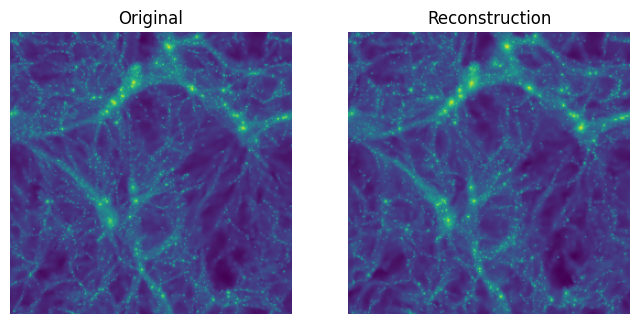

In [ ]:
# 1) Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_path = '/PATH/TO/MODEL'
dataset_path = '/PATH/TO/DATASET/'

MAP_TYPE = "Mcdm"
SUITE = "Astrid"
DATASET = "LH"
MAP_RESOLUTION = 256

mean = data.NORM_DICT[MAP_TYPE][MAP_RESOLUTION]["mean"]
std = data.NORM_DICT[MAP_TYPE][MAP_RESOLUTION]["std"]

# 2) Load model
model = represent.CosmoFlow.load_from_checkpoint(ckpt_path)
model = model.to(device).eval()

# 3) Prepare dataset (single‐sample access)
cdm_dataset = data.CAMELS(
    root=dataset_path,
    idx_list=range(0, 1),
    map_type=MAP_TYPE,
    suite=SUITE,
    dataset=DATASET,
    parameters=['Omega_m','sigma_8','A_SN1','A_SN2','A_AGN1','A_AGN2','Omega_b'],
)

# 4) Grab one image
img, cosmo_params = cdm_dataset[0]         # img shape = [C, H, W]
img_tensor = torch.tensor(img).unsqueeze(0).to(device)   # add batch dim → [1, C, H, W]

# 5) Reconstruct
with torch.no_grad():
    latent = model.encoder(img_tensor)

    # Available solvers are 'euler', 'rk4', and 'dopri5'
    recon = model.decoder.predict(
        x0=torch.randn_like(img_tensor),
        h=latent,
        n_sampling_steps=100,
        solver='euler',
    )

# 6) Plot
orig = img_tensor.cpu().squeeze().numpy()
rec  = recon.cpu().squeeze().numpy()

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(orig, cmap='viridis')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(rec, cmap='viridis')
axes[1].set_title('Reconstruction')
axes[1].axis('off')

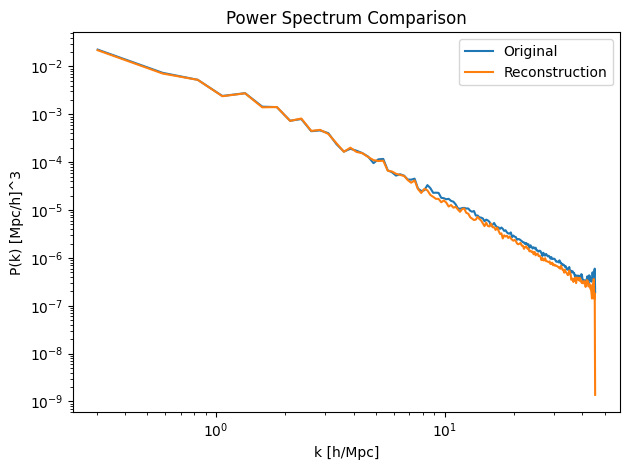

In [3]:
# Plot the power spectra of the original and reconstructed fields
import Pk_library as PKL

# Images are normalized, so we need to denormalize them
y = orig * std + mean
x1 = rec * std + mean

# Compute the overdensities
field_overdensity = y / np.mean(y) - 1
Pk2D = PKL.Pk_plane(field_overdensity, 25.0, "None", 1, verbose=False)
k_orig = Pk2D.k
Pk_orig = Pk2D.Pk

recon_overdensity = x1 / np.mean(x1) - 1
Pk2D = PKL.Pk_plane(recon_overdensity, 25.0, "None", 1, verbose=False)
k_recon = Pk2D.k
Pk_recon = Pk2D.Pk

# Plot on a log-log plot
plt.figure()
plt.loglog(k_orig, Pk_orig, label="Original")
plt.loglog(k_recon, Pk_recon, label="Reconstruction")

plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [Mpc/h]^3')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.tight_layout()
plt.show()